## Background

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
We use the dataset found from Kaggle for this the project, which is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.


## Research Question

#### 1. Explore whether patients having existing "**heart disease**" is statistically correlated to **stroke** and whether it is **robust** enough to be focal $x$ in the model. 

#### 2. Would other $variable$ / $attributes$ in this dataset might influence the casual effect of our focal $x$ - "**heart disease**" to our depending variable - "$Stroke$".

## Dataset Info

The data contains 5110 observations with 12 attributes.

Attribute Information:

    1) id: unique identifier

    2) gender: "Male", "Female" or "Other"
    
    3) age: age of the patient

    4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

    5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

    6) ever_married: "No" or "Yes"

    7) work_type: "children", "Govt_job", "Never_worked", "Private" or "Self_employed"

    8) Residence_type: "Rural" or "Urban"

    9) avg_glucose_level: average glucose level in blood

    10) bmi: body mass index

    11) smoking_status: "formerly_smoked", "never_smoked", "smokes" or "Unknown"*

    12) stroke: 1 if the patient had a stroke or 0 if not
   
   
   * Note: "Unknown" in $smoking$_$status$ means that the information is unavailable for this patient

**(Source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)**


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from numpy.linalg import inv
import scipy.stats as stats
import linearmodels.iv as iv

# Make print quality look significantly better.
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("darkgrid")

In [3]:
# read in data

stroke_df = pd.read_csv("healthcare-dataset-stroke-data_1.csv")

stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [399]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly_smoked,1
1,51676,Female,61.0,0,0,Yes,Self_employed,Rural,202.21,NaN,never_smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never_smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self_employed,Rural,174.12,24.0,never_smoked,1


In [400]:
# try to figure what is "other" in coloumn - gender

stroke_df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [401]:
stroke_df[stroke_df.gender=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly_smoked,0


In [402]:
# just 1 recorder for "other" in "gender", assuming to be error input. We decide to drop out this row.

stroke_df = stroke_df[stroke_df.gender != 'Other']
stroke_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly_smoked,1
1,51676,Female,61.0,0,0,Yes,Self_employed,Rural,202.21,NaN,never_smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never_smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self_employed,Rural,174.12,24.0,never_smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never_smoked,0
5106,44873,Female,81.0,0,0,Yes,Self_employed,Urban,125.20,40.0,never_smoked,0
5107,19723,Female,35.0,0,0,Yes,Self_employed,Rural,82.99,30.6,never_smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly_smoked,0


In [403]:
stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Data Processing

<AxesSubplot:xlabel='bmi', ylabel='Count'>

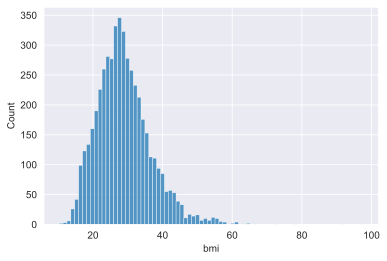

In [404]:
# dealing with NA value in "bmi"

# plot the value distribution of bmi to check if there is skewed shape before replacing NA with mean or mode
sns.histplot(stroke_df.bmi)

In [405]:
# replacing "bmi" with NA with mean value

bmi_mean = stroke_df['bmi'].mean()
#bmi_mean

stroke_df['bmi'] = stroke_df['bmi'].fillna(bmi_mean)

In [406]:
# check for any NA left

stroke_df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

<AxesSubplot:xlabel='bmi', ylabel='Count'>

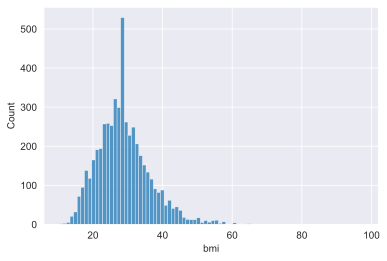

In [407]:
sns.histplot(stroke_df.bmi)

0    4860
1     249
Name: stroke, dtype: int64


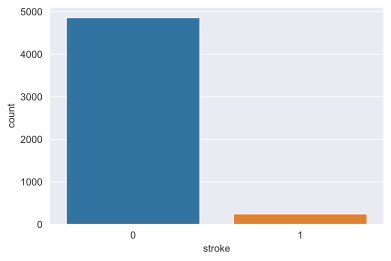

In [408]:
# check the distribution of stroke in this dataset

print(stroke_df.stroke.value_counts())

plt_stroke = sns.countplot(data=stroke_df, x="stroke")
plt.show()

### Transform categorical data into numeric before further analysis

In [409]:
# set up dummy variables
columns_selected = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
stroke_df_num = pd.get_dummies(data=stroke_df, columns=columns_selected)
stroke_df_num

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self_employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.60000,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0
1,51676,61.0,0,0,202.21,28.89456,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.50000,1,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.40000,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,1,0,174.12,24.00000,1,1,0,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,83.75,28.89456,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
5106,44873,81.0,0,0,125.20,40.00000,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
5107,19723,35.0,0,0,82.99,30.60000,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0
5108,37544,51.0,0,0,166.29,25.60000,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0


In [410]:
stroke_df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              5109 non-null   int64  
 1   age                             5109 non-null   float64
 2   hypertension                    5109 non-null   int64  
 3   heart_disease                   5109 non-null   int64  
 4   avg_glucose_level               5109 non-null   float64
 5   bmi                             5109 non-null   float64
 6   stroke                          5109 non-null   int64  
 7   gender_Female                   5109 non-null   uint8  
 8   gender_Male                     5109 non-null   uint8  
 9   ever_married_No                 5109 non-null   uint8  
 10  ever_married_Yes                5109 non-null   uint8  
 11  work_type_Govt_job              5109 non-null   uint8  
 12  work_type_Never_worked          51

* To avoid the dummy variable trap, drop out the following dummy variables for further checking multicollinearity problem (dummy variables are highly correlated to each others - **perfect collinearity** in regression).

In [411]:
# to aviod perfect collinearity & dummy variable trap
# drop out "id" (irrelevant data) & one dummy variable for each categorical variables

stroke_df_num_1=stroke_df_num.drop(['id', 'ever_married_No', 'gender_Female', 'work_type_children','Residence_type_Rural','smoking_status_Unknown'],axis=1)


stroke_df_num_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5109 non-null   float64
 1   hypertension                    5109 non-null   int64  
 2   heart_disease                   5109 non-null   int64  
 3   avg_glucose_level               5109 non-null   float64
 4   bmi                             5109 non-null   float64
 5   stroke                          5109 non-null   int64  
 6   gender_Male                     5109 non-null   uint8  
 7   ever_married_Yes                5109 non-null   uint8  
 8   work_type_Govt_job              5109 non-null   uint8  
 9   work_type_Never_worked          5109 non-null   uint8  
 10  work_type_Private               5109 non-null   uint8  
 11  work_type_Self_employed         5109 non-null   uint8  
 12  Residence_type_Urban            51

### Regress our focual $x$ - $heart$_$disease$ to the depending variable - $stroke$

$$\begin{equation} stroke =\beta_{0}+ \beta_{1} heart disease + \text{ error } \end{equation}$$

In [412]:
# consider simple regression on regressor = "heart disease"

reg_age = smf.ols(formula='stroke ~ heart_disease', data=stroke_df_num_1)
results_hd = reg_age.fit()
print('results_hd.summary(): \n{}\n'.format(results_hd.summary()))

results_hd.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     94.67
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           3.51e-22
Time:                        02:06:15   Log-Likelihood:                 643.12
No. Observations:                5109   AIC:                            -1282.
Df Residuals:                    5107   BIC:                            -1269.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.041

### Any confounding factors? 

#### **Age**

$$\begin{equation} stroke =\beta_{0}+ \beta_{1} heart disease + \beta_{2} age +\text{ error } \end{equation}$$

* Explore if $age$ is a matter as a confounding factor influencing the causal effect to **stroke**

In [413]:
# consider multiple regression on regressor = "heart_disease" + "age"

reg_hd_age = smf.ols(formula='stroke ~ heart_disease + age', data=stroke_df_num_1)
results_hd_age = reg_hd_age.fit()
print('results_hd_age.summary(): \n{}\n'.format(results_hd_age.summary()))

results_hd_age.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     178.8
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           9.10e-76
Time:                        02:06:15   Log-Likelihood:                 769.10
No. Observations:                5109   AIC:                            -1532.
Df Residuals:                    5106   BIC:                            -1513.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0

#### **Hypertension**

$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} age + 
\beta_{3} hypertension +
\text{ error } \end{equation}$$

* In general sense, high blood pressure would put an extra strain to all the blood vessels and it can more likely to make a stroke to happen.

In [414]:
# consider multiple regression on regressor = "heart_disease" + "age" + hypertension"

reg_hd_age_ht = smf.ols(formula='stroke ~ heart_disease + age + hypertension', data=stroke_df_num_1)
results_hd_age_ht = reg_hd_age_ht.fit()
print('results_hd_age_hypertension.summary(): \n{}\n'.format(results_hd_age_ht.summary()))

results_hd_age_hypertension.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     126.2
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           7.91e-79
Time:                        02:06:15   Log-Likelihood:                 778.89
No. Observations:                5109   AIC:                            -1550.
Df Residuals:                    5105   BIC:                            -1524.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

#### **Average Glucose Level**

$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} age + 
\beta_{3} hypertension + 
\beta_{4} avg glucose lv +
\text{ error } \end{equation}$$

* Elevated blood glucose is common in the early phase of stroke because diabetes is a well-established risk factor for stroke. It can cause pathologic changes in blood vessels at various locations and can lead to stroke if cerebral vessels (at brain) are directly affected.


In [415]:
# consider multiple regression on regressor = "heart_disease" + "age" + hyertension" + "avg_glucose_level"

reg_hd_age_ht_glu = smf.ols(formula='stroke ~ heart_disease + age + hypertension + avg_glucose_level', data=stroke_df_num_1)
results_hd_age_ht_glu = reg_hd_age_ht_glu.fit()
print('results_heartdisease_age_hypertension_avg_glucose_level.summary(): \n{}\n'.format(results_hd_age_ht_glu.summary()))

results_heartdisease_age_hypertension_avg_glucose_level.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     100.3
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           2.61e-82
Time:                        02:06:15   Log-Likelihood:                 789.48
No. Observations:                5109   AIC:                            -1569.
Df Residuals:                    5104   BIC:                            -1536.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

#### **BMI**

$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} age + 
\beta_{3} hypertension + 
\beta_{4} avg glucose lv + 
\beta_{5} bmi + 
\text{ error } \end{equation}$$


* According Centers for Disease Control and Prevention (CDC), Obesity/Overweight are primary risk factors for stroke for men and women of all races. Body Mass Index (BMI) is used to calcuate the ideal weight. A BMI between 25-30 is considered overweight, while a BMI of over 30 is considered obese, in which higher risk to get stroke.

(source: https://www.cdc.gov/obesity/adult/causes.html)


In [416]:
# consider multiple regression on regressor = "heart_disease" + "age" + hyertension" + "avg_glucose_level" + "BMI"

reg_hd_age_ht_glu_bmi = smf.ols(formula='stroke ~ heart_disease + age + hypertension + avg_glucose_level + bmi', data=stroke_df_num_1)
results_hd_age_ht_glu_bmi = reg_hd_age_ht_glu_bmi.fit()
print('results_heartdisease_age_hypertension_avg_glucose_level_bmi.summary(): \n{}\n'.format(results_hd_age_ht_glu_bmi.summary()))

results_heartdisease_age_hypertension_avg_glucose_level_bmi.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     83.29
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           2.37e-84
Time:                        02:06:15   Log-Likelihood:                 796.61
No. Observations:                5109   AIC:                            -1581.
Df Residuals:                    5103   BIC:                            -1542.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

#### **Gender**

$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} age + 
\beta_{3} hypertension + 
\beta_{4} avg glucose lv + 
\beta_{5} bmi + 
\beta_{5} gender(Male) + 
\text{ error } \end{equation}$$


* Explore if gender (compare being MALE to being Female) is a matter to influence the casual effect to **stroke**

In [417]:
# consider multiple regression on regressor = "heart_disease" + "age" + hyertension" + "avg_glucose_level" + "BMI" + "gender(Male)"

reg_hd_age_ht_glu_bmi_M = smf.ols(formula='stroke ~ heart_disease + age + hypertension + avg_glucose_level + bmi + gender_Male', data=stroke_df_num_1)
results_hd_age_ht_glu_bmi_M = reg_hd_age_ht_glu_bmi_M.fit()
print('results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M).summary(): \n{}\n'.format(results_hd_age_ht_glu_bmi_M.summary()))

results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M).summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     69.41
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           2.22e-83
Time:                        02:06:15   Log-Likelihood:                 796.64
No. Observations:                5109   AIC:                            -1579.
Df Residuals:                    5102   BIC:                            -1534.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------


#### **Ever Married**

$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} age + 
\beta_{3} hypertension + 
\beta_{4} avg glucose lv + 
\beta_{5} bmi + 
\beta_{6} gender(Male) + 
\beta_{7} ever married(Yes) +
\text{ error } \end{equation}$$


* Explore if marry (being married comparing to not married) is a matter to influence the casual effect to **stroke**

In [418]:
# consider multiple regression on regressor = "heart_disease" + "age" + hyertension" + "avg_glucose_level" + "BMI" + "gender(Male)" + "married(Yes)"

reg_hd_age_ht_glu_bmi_M_married = smf.ols(formula='stroke ~ heart_disease + age + hypertension + avg_glucose_level + bmi + gender_Male + ever_married_Yes', data=stroke_df_num_1)
results_hd_age_ht_glu_bmi_M_married = reg_hd_age_ht_glu_bmi_M_married.fit()
print('results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M)_married.summary(): \n{}\n'.format(results_hd_age_ht_glu_bmi_M_married.summary()))

results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M)_married.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     62.99
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           2.65e-87
Time:                        02:06:15   Log-Likelihood:                 807.98
No. Observations:                5109   AIC:                            -1600.
Df Residuals:                    5101   BIC:                            -1548.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

#### **Work Type**


$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} age + 
\beta_{3} hypertension + 
\beta_{4} avg glucose lv + 
\beta_{5} bmi + 
\beta_{6} gender(Male) + 
\beta_{7} ever married(Yes) +
\beta_{8} worktype(GovtJob) +
\beta_{9} worktype(NeverWorked) +
\beta_{10} worktype(Private) +
\beta_{11} worktype(SelfEmployed) +
\text{ error }\end{equation}$$


* Different type of work features would create different kind of stress to people. 
* In this dataset, we are comparing "$being$ $children$ (not yet to work)" with 4 types of job status (Mature but never worked, Private, Government Job, Self-Employed) to categorise the patients' occupation.



In [419]:
# consider multiple regression on regressor = "heart_disease" + "age" + hyertension" + "avg_glucose_level" + "BMI" + "gender(Male)" + "married(Yes)" +"Work_Type"

reg_hd_age_ht_glu_bmi_M_married_work = smf.ols(formula='stroke ~ heart_disease + age + hypertension + \
                                            avg_glucose_level + \
                                            bmi + \
                                            gender_Male + \
                                            ever_married_Yes + \
                                            work_type_Govt_job +\
                                            work_type_Never_worked +\
                                            work_type_Private + \
                                            work_type_Self_employed', data=stroke_df_num_1)
results_hd_age_ht_glu_bmi_M_married_work = reg_hd_age_ht_glu_bmi_M_married_work.fit()
print('results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M)_married_work.summary(): \n{}\n'.format(results_hd_age_ht_glu_bmi_M_married_work.summary()))

results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M)_married_work.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     42.53
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           3.82e-89
Time:                        02:06:15   Log-Likelihood:                 820.54
No. Observations:                5109   AIC:                            -1617.
Df Residuals:                    5097   BIC:                            -1539.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

#### **Residence Type**


$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} age + 
\beta_{3} hypertension + 
\beta_{4} avg glucose lv + 
\beta_{5} bmi + 
\beta_{6} gender(Male) + 
\beta_{7} ever married(Yes) +
\beta_{8} worktype(GovtJob) +
\beta_{9} worktype(NeverWorked) +
\beta_{10} worktype(Private) +
\beta_{11} worktype(SelfEmployed) +
\beta_{12} Residence_type_Urban +
\text{ error } \end{equation}$$


* explaore living urban (comparing to living rural area) is a matter to influence the casual effect to **stroke**


In [420]:
# consider multiple regression on regressor = "heart_disease" + "age" + hyertension" + "avg_glucose_level" + "BMI" + "gender(Male)" + "married(Yes)" + "Work_Type" + "residence(urban)" 

reg_hd_age_ht_glu_bmi_M_married_work_urban = smf.ols(formula='stroke ~ heart_disease + age + hypertension + \
                                            avg_glucose_level + \
                                            bmi + \
                                            gender_Male + \
                                            ever_married_Yes + \
                                            work_type_Govt_job +\
                                            work_type_Never_worked +\
                                            work_type_Private + \
                                            work_type_Self_employed +\
                                            Residence_type_Urban', data=stroke_df_num_1)
results_hd_age_ht_glu_bmi_M_married_work_urban = reg_hd_age_ht_glu_bmi_M_married_work_urban.fit()
print('results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M)_married_work_urban.summary(): \n{}\n'.format(results_hd_age_ht_glu_bmi_M_married_work_urban.summary()))

results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M)_married_work_urban.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     39.06
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           1.67e-88
Time:                        02:06:15   Log-Likelihood:                 820.98
No. Observations:                5109   AIC:                            -1616.
Df Residuals:                    5096   BIC:                            -1531.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------

#### **Smoking Status**


$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} age + 
\beta_{3} hypertension + 
\beta_{4} avg glucose lv + 
\beta_{5} bmi + 
\beta_{5} gender(Male) + 
\beta_{6} ever married(Yes) +
\beta_{7} worktype(GovtJob) +
\beta_{8} worktype(NeverWorked) +
\beta_{9} worktype(Private) +
\beta_{10} worktype(SelfEmployed) +
\beta_{11} Residence_type(Urban) +
\beta_{12} smokingstatus(FormerlySmoked) +
\beta_{13} smokingstatus(NeverSmoked) +
\beta_{14} smokingstatus(Smokes) +
\text{ error } \end{equation}$$


* explore smoking status (comparing 3 different smoking habit to people declared "unknown" on their smoking habit) is a matter to influence the casual effect to **stroke**

In [421]:
# consider multiple regression on regressor = "heart_disease" + "age" + hyertension" + "avg_glucose_level" + "BMI" + "gender(Male)" + "married(Yes)" +"Work_Type" + "residence(urban)" + "smoking_status"

reg_hd_age_ht_glu_bmi_M_married_work_urban_smok = smf.ols(formula='stroke ~ heart_disease + age + hypertension + \
                                            avg_glucose_level + \
                                            bmi + \
                                            gender_Male + \
                                            ever_married_Yes + \
                                            work_type_Govt_job +\
                                            work_type_Never_worked +\
                                            work_type_Private + \
                                            work_type_Self_employed +\
                                            Residence_type_Urban +\
                                            smoking_status_formerly_smoked +\
                                            smoking_status_never_smoked +\
                                            smoking_status_smokes', data=stroke_df_num_1)
results_hd_age_ht_glu_bmi_M_married_work_urban_smok = reg_hd_age_ht_glu_bmi_M_married_work_urban_smok.fit()
print('results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M)_married_work_urban_smoking.summary(): \n{}\n'.format(results_hd_age_ht_glu_bmi_M_married_work_urban_smok.summary()))

results_heartdisease_age_hypertension_avg_glucose_level_bmi_Gender(M)_married_work_urban_smoking.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     31.34
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           1.89e-86
Time:                        02:06:15   Log-Likelihood:                 821.72
No. Observations:                5109   AIC:                            -1611.
Df Residuals:                    5093   BIC:                            -1507.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--

###  Consider multicollinearity problem - Checking the correlation between variables

<AxesSubplot:title={'center':'Correlation Heatmap between different variables'}>

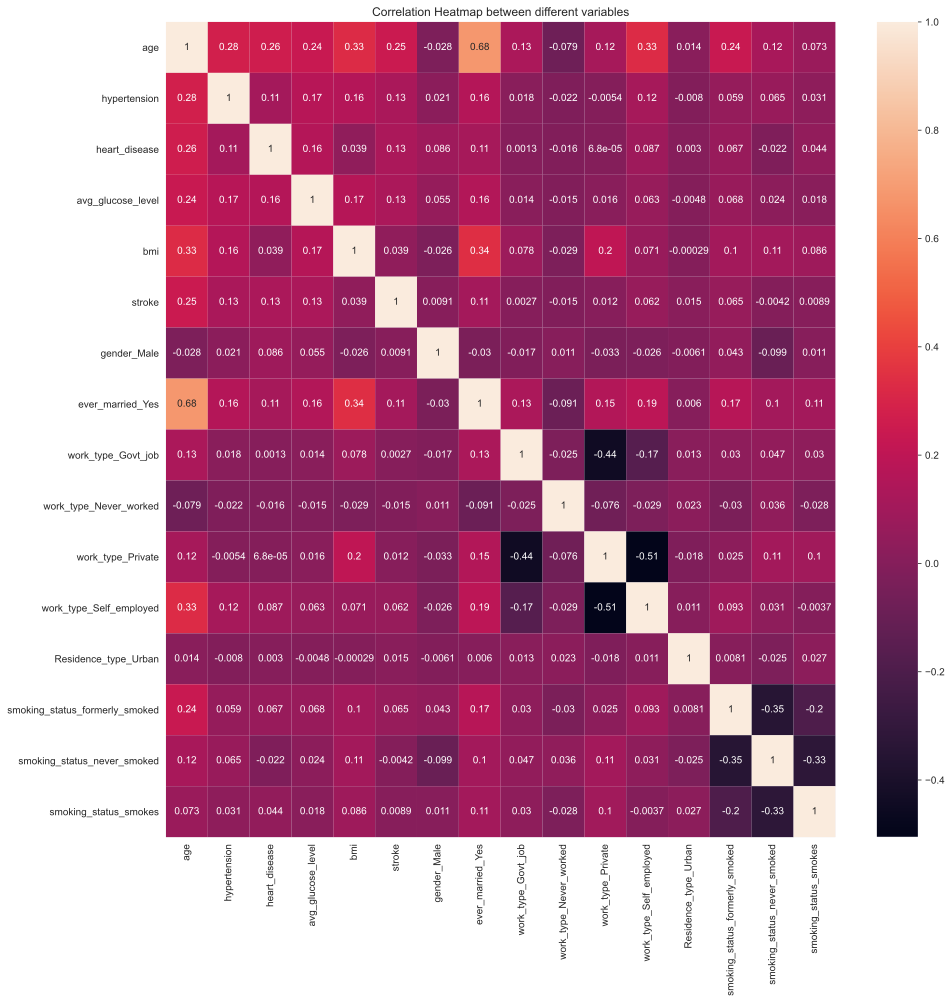

In [422]:
# heatmap
plt.subplots(figsize=(15,15))
ax = plt.axes()
ax.set_title("Correlation Heatmap between different variables")
corr = stroke_df_num_1.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True)

We use **Variance Inflation Factor (VIF)** to evaluate whether there is **multicollinearity problem** in this dataset. 

In [423]:
# the independent variables set
X = stroke_df_num[['age',
                   'hypertension',
                   'heart_disease',
                   'avg_glucose_level',
                   'bmi',
                   'stroke',
                   'gender_Male',
                  'ever_married_Yes',
                  'work_type_Never_worked',
                  'work_type_Private',
                  'work_type_Self_employed',
                  'work_type_Govt_job',
                  'Residence_type_Urban',
                  'smoking_status_formerly_smoked',
                  'smoking_status_never_smoked',
                  'smoking_status_smokes']]

# VIF dataframe
vif_stroke_df_num = pd.DataFrame()
vif_stroke_df_num["feature"] = X.columns

# calculating VIF for each feature
vif_stroke_df_num["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(len(X.columns))]

print(vif_stroke_df_num)

                           feature        VIF
0                              age  13.828467
1                     hypertension   1.222389
2                    heart_disease   1.176401
3                avg_glucose_level   6.234775
4                              bmi  12.865932
5                           stroke   1.146732
6                      gender_Male   1.676116
7                 ever_married_Yes   5.713125
8           work_type_Never_worked   1.043329
9                work_type_Private  10.960264
10         work_type_Self_employed   4.557899
11              work_type_Govt_job   3.518001
12            Residence_type_Urban   1.939425
13  smoking_status_formerly_smoked   1.935630
14     smoking_status_never_smoked   2.849320
15           smoking_status_smokes   1.814536


* We have the 3 variables with **high** multicollinearity problem with other variables within this dataset
* From the above multiple regression to $stroke$, we try to minimize the multicollinearity problem by taking out those variables which are not statisically significant to $stroke$

1. bmi
2. gender_Male 
3. work_type_Never_worked
4. Residence_type_Urban              
5. smoking_status_formerly_smoked 
6. smoking_status_never_smoked
7. smoking_status_smokes

In [424]:
# the independent variables set - taking out:
#1. bmi
#2. gender_Male 
#3. work_type_Never_worked
#4. Residence_type_Urban              
#5. smoking_status_formerly_smoked 
#6. smoking_status_never_smoked
#7. smoking_status_smokes

X_1 = stroke_df_num[['age',
                   'hypertension',
                   'heart_disease',
                   'avg_glucose_level',
                   'stroke',
                   'ever_married_Yes',
                   'work_type_Private',
                   'work_type_Self_employed',
                   'work_type_Govt_job'
                    ]]

# VIF dataframe
vif_stroke_df_num_1 = pd.DataFrame()
vif_stroke_df_num_1["feature"] = X_1.columns

# calculating VIF for each feature
vif_stroke_df_num_1["VIF"] = [variance_inflation_factor(X_1.values, i)
                   for i in range(len(X_1.columns))]

print(vif_stroke_df_num_1)

                   feature        VIF
0                      age  13.543150
1             hypertension   1.213692
2            heart_disease   1.160492
3        avg_glucose_level   4.448741
4                   stroke   1.142191
5         ever_married_Yes   5.677276
6        work_type_Private   6.569213
7  work_type_Self_employed   3.390808
8       work_type_Govt_job   2.507616


* After this, we still have variable ($age$) with high multicollinearity problem. We would take out this variable.
* The $age$ has a high multicollinearity problem, it is probably is beacause $age$ have high correlations with other variables like glucose level, hypertension, heart-disease, worktype in this dataset, according the above corralation heatmap.

In [425]:
# the independent variables set taking out:
#1. age

X_2 = stroke_df_num[['hypertension',
                    'heart_disease',
                    'avg_glucose_level',
                    'stroke',
                    'ever_married_Yes',
                    'work_type_Private',
                    'work_type_Self_employed',
                    'work_type_Govt_job'
                    ]]

# VIF dataframe
vif_stroke_df_num_2 = pd.DataFrame()
vif_stroke_df_num_2["feature"] = X_2.columns

# calculating VIF for each feature
vif_stroke_df_num_2["VIF"] = [variance_inflation_factor(X_2.values, i)
                   for i in range(len(X_2.columns))]

print(vif_stroke_df_num_2)

                   feature       VIF
0             hypertension  1.181595
1            heart_disease  1.109341
2        avg_glucose_level  4.242081
3                   stroke  1.098500
4         ever_married_Yes  4.381272
5        work_type_Private  4.620613
6  work_type_Self_employed  2.299941
7       work_type_Govt_job  1.943859


### Structure model **without** the multicollinearity problem 

$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} hypertension + 
\beta_{3} avg glucose lv + 
\beta_{4} ever married(Yes) +
\beta_{5} worktype(GovtJob) +
\beta_{6} worktype(Private) +
\beta_{7} worktype(SelfEmployed) +
\text{ error } \end{equation}$$



In [426]:
# get a regression summary after taking out the multicollinearity problem from the above model


reg_stroke_StructureModel = smf.ols(formula='stroke ~ hypertension +\
                            heart_disease +\
                            avg_glucose_level +\
                            ever_married_Yes +\
                            work_type_Private +\
                            work_type_Self_employed +\
                            work_type_Govt_job', data=stroke_df_num_1)
results_stroke_StructureModel = reg_stroke_StructureModel.fit()
print('result_stroke_StructureModel.summary(): \n{}\n'.format(results_stroke_StructureModel.summary()))

result_stroke_StructureModel.summary(): 
                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     34.76
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           1.09e-47
Time:                        02:06:18   Log-Likelihood:                 715.24
No. Observations:                5109   AIC:                            -1414.
Df Residuals:                    5101   BIC:                            -1362.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### Testing for Endogeneity for $heart$_$disease$

We are now testing whether $heart disease$ is endogenous.



Suppose the **structural model**: 

$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} hypertension + 
\beta_{3} avg glucose lv + 
\beta_{4} ever married(Yes) +
\beta_{5} worktype(GovtJob) +
\beta_{6} worktype(Private) +
\beta_{7} worktype(SelfEmployed) +
u_{1} \end{equation}$$


where $heart$_$disease$ is suspected **endogenous**


* We also have available **IVs** $z_3$ and $z_4$ excluded from the above model. In terms of the first stage **linear prediction model** of $$\begin{equation}
y_{2}=\pi_{0}+\pi_{1} z_{1}+\pi_{2} z_{2}+\pi_{3} z_{3}+\pi_{4} z_{4}+v_{2}
\end{equation}$$ 


* We would know that "heart disease" is not endogenous ONLY IF the residuals $v_{2}$ is _uncorrelated_ to $u_{1}$ in the **structural model**. from the first stage linear prediction model is incorrelated to the above structural model for "stroke".

* Failing to reject $\mathbf{H}_0: \delta_1 = 0$ indicates that no obvious evidence for **endogeneity** of $y_2$

### Testing for Endogeneity - $heart disease$

$\mathbf{H}_0: \delta_1 = 0$ indicates that it has no evidence for **endogeneity** on our focal $x$ - "heart disease"

In [427]:

# 1st stage (reduced form):
reg_redf_stroke = smf.ols(formula='heart_disease ~ age+bmi + hypertension +\
                                    avg_glucose_level + ever_married_Yes +\
                                    work_type_Private + work_type_Self_employed +\
                                    work_type_Govt_job',
                   data=stroke_df_num_1)
results_redf_stroke = reg_redf_stroke.fit()
stroke_df_num_1['resid'] = results_redf_stroke.resid

In [428]:

# 2nd stage:
reg_secstg_stroke = smf.ols(formula='stroke~ resid + \
                                    heart_disease + hypertension +\
                                    avg_glucose_level + ever_married_Yes +\
                                    work_type_Private + work_type_Self_employed +\
                                    work_type_Govt_job',
                             data=stroke_df_num_1)
results_secstg_stroke = reg_secstg_stroke.fit()

In [429]:
# print regression table:
table_secstg_stroke = pd.DataFrame({'b': round(results_secstg_stroke.params, 4),
                             'se': round(results_secstg_stroke.bse, 4),
                             't': round(results_secstg_stroke.tvalues, 4),
                             'pval': round(results_secstg_stroke.pvalues, 4)})
print(f'table_secstg: \n{table_secstg_stroke}\n')

table_secstg: 
                              b      se        t    pval
Intercept                0.0127  0.0105   1.2107  0.2261
resid                   -0.8438  0.0577 -14.6325  0.0000
heart_disease            0.8943  0.0561  15.9462  0.0000
hypertension             0.0237  0.0104   2.2787  0.0227
avg_glucose_level       -0.0001  0.0001  -1.5644  0.1178
ever_married_Yes         0.0024  0.0076   0.3124  0.7547
work_type_Private       -0.0015  0.0102  -0.1426  0.8866
work_type_Self_employed -0.0147  0.0128  -1.1525  0.2492
work_type_Govt_job      -0.0033  0.0128  -0.2622  0.7932



**Result:** The P-Value of resid is close to **$0$**. We reject $\mathbf{H}_0: \delta_1 = 0$ indicates that it has evidence for **endogeneity** on our focal $x$ - "heart disease".

### Running Multiple Regression to **$heart$_$disease$** VS all existing variables

* We try to see which existing variables in this dataset may have significant influence to $heart disease$, which may have potential to be considered as our intrumental variable (IV).


In [430]:
# regress all the existing variables in this dataset to heart_disease

reg_hd_all = smf.ols(formula='heart_disease ~ age + hypertension + \
                                            avg_glucose_level + \
                                            bmi + \
                                            gender_Male + \
                                            ever_married_Yes + \
                                            work_type_Govt_job +\
                                            work_type_Never_worked +\
                                            work_type_Private + \
                                            work_type_Self_employed +\
                                            Residence_type_Urban +\
                                            smoking_status_formerly_smoked +\
                                            smoking_status_never_smoked +\
                                            smoking_status_smokes', data=stroke_df_num_1)
results_hd_all = reg_hd_all.fit()
print('results_heartdisease_all.summary(): \n{}\n'.format(results_hd_all.summary()))

results_heartdisease_all.summary(): 
                            OLS Regression Results                            
Dep. Variable:          heart_disease   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     41.74
Date:                Fri, 23 Apr 2021   Prob (F-statistic):          3.48e-109
Time:                        02:06:18   Log-Likelihood:                 624.87
No. Observations:                5109   AIC:                            -1220.
Df Residuals:                    5094   BIC:                            -1122.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Applying Instrumental variable (IV) on strurtural model

* Given the limitation of the sample dataset we have here, with the given 12 attributes, we understand that there are more paremter and data are unobserved and missing for this study of causal effect of "heart disease" on getting "stroke". For example, genetic issue, family medical history, psychological health, ability to manage stress, other bad hahits from lifestyle of those patients, sudden ancident happened from the patients etc.

* Some of those missing or unobserved variables may contribute and lead the stroke to happen on these surveyed patients. 

* Based on some research studies about the potential factors leading to heart disease and stroke, we can find that bmi is significiant indicator to heart disease, it increase the risk of getting stroke. Therefore, it is reasonable to think that it may have indirectly causal effect to $stroke$ through the people with existing heart disease based on our dataset.

* Some articles even mentioned that stroke occurred at a significantly younger age in patients with high BMI. 

(https://www.verywellhealth.com/being-overweight-and-stroke-risk-3146345)

(https://strokeprevention.info/risk-factor-obesity/5-facts-about-obesity-and-stroke-risk/)

(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4458137/)

(https://bmjopen.bmj.com/content/5/9/e008105)



* In addition, **$bmi$** is a statistically significant variable to **$heart$_$disease$** , but not to our depending variable - **$stroke$** from the above confounding factors workout.  

* We try to setup both **$bmi$** and **$age$** as the Instrumental Variable (IV) to heart disease and do the 2SlS estimate to check whether this assumption is valid, based on this dataset.





In [431]:
# IV set up:

stroke_iv = iv.IV2SLS.from_formula(
    formula='stroke~ 1 + hypertension +\
            avg_glucose_level + ever_married_Yes +\
            work_type_Private + work_type_Self_employed +\
            work_type_Govt_job +[heart_disease ~  age+bmi ]',
    data=stroke_df_num_1)
results_stroke_iv = stroke_iv.fit(cov_type='unadjusted', debiased=True)

# print regression table:
table_stroke_iv = pd.DataFrame({'b': round(results_stroke_iv.params, 4),
                         'se': round(results_stroke_iv.std_errors, 4),
                         't': round(results_stroke_iv.tstats, 4),
                         'pval': round(results_stroke_iv.pvalues, 4)})
print(f'table_iv: \n{table_stroke_iv}\n')

table_iv: 
                              b      se        t    pval
Intercept                0.0127  0.0140   0.9087  0.3636
hypertension             0.0237  0.0139   1.7103  0.0873
avg_glucose_level       -0.0001  0.0001  -1.1742  0.2404
ever_married_Yes         0.0024  0.0101   0.2345  0.8146
work_type_Private       -0.0015  0.0136  -0.1070  0.9148
work_type_Self_employed -0.0147  0.0170  -0.8650  0.3871
work_type_Govt_job      -0.0033  0.0170  -0.1968  0.8440
heart_disease            0.8943  0.0747  11.9684  0.0000



In [432]:
results_stroke_iv

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                 stroke   R-squared:                     -0.6264
Estimator:                    IV-2SLS   Adj. R-squared:                -0.6286
No. Observations:                5109   F-statistic:                    36.489
Date:                Fri, Apr 23 2021   P-value (F-stat)                0.0000
Time:                        02:06:18   Distribution:                F(7,5101)
Cov. Estimator:            unadjusted                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                   0.0127     0.0140     0.9087     0.3636     -0.0147      0.0401
hypertension                0.0237     0.0139     1.7103     0.0873     -0.0035      0.0509
avg_glucose_level          -0.0001     0.0001    -1.1742     0.2404     -0.0003   7.909e-05
ever_married_Yes            0.0024     0.0101     0.2345     0.8146     -0.0175      0.0222
work_type_Private          -0.0015     0.0136    -0.1070     0.9148     -0.0281      0.0252
work_type_Self_employed    -0.0147     0.0170    -0.8650     0.3871     -0.0481      0.0186
work_type_Govt_job         -0.0033     0.0170    -0.1968     0.8440     -0.0367      0.0300
heart_disease               0.8943     0.0747     11.968     0.0000      0.7478      1.0408
===========================================================================================

Endogenous: heart_disease
Instruments: age, bmi
Unadjusted Covariance (Homoskedastic)
Debiased: True
IVResults, id: 0x1cbd6938700

### Sargan test for instrument validity

Under the Null hypothesis $\mathbf{H}_0$ that all **IVs** are _uncorrelated_ with $u_1$, the residuals of the structural model.

In [433]:
# IV set up:

stroke_iv = iv.IV2SLS.from_formula(
    formula='stroke~ 1 + hypertension +\
            avg_glucose_level + ever_married_Yes +\
            work_type_Private + work_type_Self_employed +\
            work_type_Govt_job +[heart_disease ~  bmi + age  ]',
    data=stroke_df_num_1)
results_stroke_iv = stroke_iv.fit(cov_type='unadjusted', debiased=True)

# print regression table:
table_stroke_iv = pd.DataFrame({'b': round(results_stroke_iv.params, 4),
                         'se': round(results_stroke_iv.std_errors, 4),
                         't': round(results_stroke_iv.tstats, 4),
                         'pval': round(results_stroke_iv.pvalues, 4)})
print(f'table_iv: \n{table_stroke_iv}\n')

table_iv: 
                              b      se        t    pval
Intercept                0.0127  0.0140   0.9087  0.3636
hypertension             0.0237  0.0139   1.7103  0.0873
avg_glucose_level       -0.0001  0.0001  -1.1742  0.2404
ever_married_Yes         0.0024  0.0101   0.2345  0.8146
work_type_Private       -0.0015  0.0136  -0.1070  0.9148
work_type_Self_employed -0.0147  0.0170  -0.8650  0.3871
work_type_Govt_job      -0.0033  0.0170  -0.1968  0.8440
heart_disease            0.8943  0.0747  11.9684  0.0000



In [434]:
# auxiliary regression:
stroke_df_num_1['resid_iv'] = results_stroke_iv.resids
reg_stroke_aux = smf.ols(formula='resid_iv ~  hypertension +\
                                avg_glucose_level + ever_married_Yes +\
                                work_type_Private + work_type_Self_employed +\
                                work_type_Govt_job + bmi + age ',
                  data=stroke_df_num_1)
results_stroke_aux = reg_stroke_aux.fit()

In [435]:
# calculations for test:
r2 = results_stroke_aux.rsquared
n = results_stroke_aux.nobs
teststat = n * r2
pval = 1 - stats.chi2.cdf(teststat, 1)

print(f'r2: {r2}\n')
print(f'n: {n}\n')
print(f'teststat: {teststat}\n')
print(f'pval: {pval}\n')

r2: 5.064657789044524e-06

n: 5109.0

teststat: 0.025875336644228475

pval: 0.8722051434776941



**Result:** Baesd on the P-value of 0.87, we cannot reject null $\mathbf{H}_0$. The **IVs** (**bmi** & **age**) are exogenous.

### Testing For Heteroskedasticity Problem

### Robust standard errors in OLS

#### Structure model without the multicollinearity problem 

$$\begin{equation} stroke =\beta_{0}+ 
\beta_{1} heart disease + 
\beta_{2} hypertension + 
\beta_{3} avg glucose lv + 
\beta_{4} ever married(Yes) +
\beta_{5} worktype(GovtJob) +
\beta_{6} worktype(Private) +
\beta_{7} worktype(SelfEmployed) +
\text{ error } \end{equation}$$

In [436]:
# OLS - Robust Standard Errors - HC0

RSE_stroke_robust_HC0 = results_stroke_StructureModel.get_robustcov_results(cov_type='HC0')

print(RSE_stroke_robust_HC0.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     27.95
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           5.45e-38
Time:                        02:06:19   Log-Likelihood:                 715.24
No. Observations:                5109   AIC:                            -1414.
Df Residuals:                    5101   BIC:                            -1362.
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [437]:
# OLS - Robust Standard Errors - HC1

RSE_stroke_robust_HC1 = results_stroke_StructureModel.get_robustcov_results(cov_type='HC1')

print(RSE_stroke_robust_HC1.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     27.91
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           6.29e-38
Time:                        02:06:19   Log-Likelihood:                 715.24
No. Observations:                5109   AIC:                            -1414.
Df Residuals:                    5101   BIC:                            -1362.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [438]:
# OLS - Robust Standard Errors - HC2

RSE_stroke_robust_HC2 = results_stroke_StructureModel.get_robustcov_results(cov_type='HC2')

print(RSE_stroke_robust_HC2.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     27.87
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           7.06e-38
Time:                        02:06:19   Log-Likelihood:                 715.24
No. Observations:                5109   AIC:                            -1414.
Df Residuals:                    5101   BIC:                            -1362.
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [439]:
# OLS - Robust Standard Errors - HC3

RSE_stroke_robust_HC3 = results_stroke_StructureModel.get_robustcov_results(cov_type='HC3')

print(RSE_stroke_robust_HC3.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     27.79
Date:                Fri, 23 Apr 2021   Prob (F-statistic):           9.13e-38
Time:                        02:06:19   Log-Likelihood:                 715.24
No. Observations:                5109   AIC:                            -1414.
Df Residuals:                    5101   BIC:                            -1362.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### Robust standard errors in 2SLS

In [440]:
# IV 2SLS:robust

stroke_iv = iv.IV2SLS.from_formula(
    formula='stroke~ 1 + hypertension +\
            avg_glucose_level + ever_married_Yes +\
            work_type_Private + work_type_Self_employed +\
            work_type_Govt_job +[heart_disease ~  bmi + age  ]',
    data=stroke_df_num_1)
results_stroke_iv_robust = stroke_iv.fit(cov_type='robust', debiased=True)

# print regression table:
table_stroke_iv_robust = pd.DataFrame({'b': round(results_stroke_iv_robust.params, 4),
                         'se': round(results_stroke_iv_robust.std_errors, 4),
                         't': round(results_stroke_iv_robust.tstats, 4),
                         'pval': round(results_stroke_iv_robust.pvalues, 4)})
print(f'table_iv_Robust: \n{table_stroke_iv_robust}\n')

table_iv_Robust: 
                              b      se       t    pval
Intercept                0.0127  0.0128  0.9907  0.3219
hypertension             0.0237  0.0207  1.1433  0.2530
avg_glucose_level       -0.0001  0.0001 -0.8856  0.3759
ever_married_Yes         0.0024  0.0088  0.2699  0.7872
work_type_Private       -0.0015  0.0058 -0.2523  0.8008
work_type_Self_employed -0.0147  0.0141 -1.0400  0.2984
work_type_Govt_job      -0.0033  0.0126 -0.2652  0.7908
heart_disease            0.8943  0.0991  9.0254  0.0000



In [441]:
results_stroke_iv_robust

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                 stroke   R-squared:                     -0.6264
Estimator:                    IV-2SLS   Adj. R-squared:                -0.6286
No. Observations:                5109   F-statistic:                    19.600
Date:                Fri, Apr 23 2021   P-value (F-stat)                0.0000
Time:                        02:06:19   Distribution:                F(7,5101)
Cov. Estimator:                robust                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                   0.0127     0.0128     0.9907     0.3219     -0.0124      0.0379
hypertension                0.0237     0.0207     1.1433     0.2530     -0.0169      0.0644
avg_glucose_level          -0.0001     0.0001    -0.8856     0.3759     -0.0004      0.0001
ever_married_Yes            0.0024     0.0088     0.2699     0.7872     -0.0149      0.0196
work_type_Private          -0.0015     0.0058    -0.2523     0.8008     -0.0128      0.0099
work_type_Self_employed    -0.0147     0.0141    -1.0400     0.2984     -0.0425      0.0130
work_type_Govt_job         -0.0033     0.0126    -0.2652     0.7908     -0.0281      0.0214
heart_disease               0.8943     0.0991     9.0254     0.0000      0.7000      1.0885
===========================================================================================

Endogenous: heart_disease
Instruments: bmi, age
Robust Covariance (Heteroskedastic)
Debiased: True
IVResults, id: 0x1cbd694ba60

In [442]:
# IV 2SLS:unadjusted

stroke_iv = iv.IV2SLS.from_formula(
    formula='stroke~ 1 + hypertension +\
            avg_glucose_level + ever_married_Yes +\
            work_type_Private + work_type_Self_employed +\
            work_type_Govt_job +[heart_disease ~  bmi + age  ]',
    data=stroke_df_num_1)
results_stroke_iv= stroke_iv.fit(cov_type='unadjusted', debiased=True)

# print regression table:
table_stroke_iv = pd.DataFrame({'b': round(results_stroke_iv.params, 4),
                         'se': round(results_stroke_iv.std_errors, 4),
                         't': round(results_stroke_iv.tstats, 4),
                         'pval': round(results_stroke_iv.pvalues, 4)})
print(f'table_iv_Unadjusted: \n{table_stroke_iv}\n')

table_iv_Unadjusted: 
                              b      se        t    pval
Intercept                0.0127  0.0140   0.9087  0.3636
hypertension             0.0237  0.0139   1.7103  0.0873
avg_glucose_level       -0.0001  0.0001  -1.1742  0.2404
ever_married_Yes         0.0024  0.0101   0.2345  0.8146
work_type_Private       -0.0015  0.0136  -0.1070  0.9148
work_type_Self_employed -0.0147  0.0170  -0.8650  0.3871
work_type_Govt_job      -0.0033  0.0170  -0.1968  0.8440
heart_disease            0.8943  0.0747  11.9684  0.0000



In [443]:
results_stroke_iv

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                 stroke   R-squared:                     -0.6264
Estimator:                    IV-2SLS   Adj. R-squared:                -0.6286
No. Observations:                5109   F-statistic:                    36.489
Date:                Fri, Apr 23 2021   P-value (F-stat)                0.0000
Time:                        02:06:19   Distribution:                F(7,5101)
Cov. Estimator:            unadjusted                                         
                                                                              
                                    Parameter Estimates                                    
===========================================================================================
                         Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------------
Intercept                   0.0127     0.0140     0.9087     0.3636     -0.0147      0.0401
hypertension                0.0237     0.0139     1.7103     0.0873     -0.0035      0.0509
avg_glucose_level          -0.0001     0.0001    -1.1742     0.2404     -0.0003   7.909e-05
ever_married_Yes            0.0024     0.0101     0.2345     0.8146     -0.0175      0.0222
work_type_Private          -0.0015     0.0136    -0.1070     0.9148     -0.0281      0.0252
work_type_Self_employed    -0.0147     0.0170    -0.8650     0.3871     -0.0481      0.0186
work_type_Govt_job         -0.0033     0.0170    -0.1968     0.8440     -0.0367      0.0300
heart_disease               0.8943     0.0747     11.968     0.0000      0.7478      1.0408
===========================================================================================

Endogenous: heart_disease
Instruments: bmi, age
Unadjusted Covariance (Homoskedastic)
Debiased: True
IVResults, id: 0x1cbd6bdccd0

### Conclusion

* By going through the about workout on confounding factors and tests, we conclude that the focal $x$ - $heart disease$ is stable to create **Positive** casual effect to our depending variable $stroke$.


* However, the standard error from $heart disease$ under IV setting up is larger than the stand alone $heart disease$ to our depending variable - $stroke$. It seems the instrumental variables ($age$ and $bmi$) create additional noise with the observed $\boldsymbol{\beta}$ of $heart disease$ (0.8943) is greater than the $\boldsymbol{\beta}$ found in the structure model (0.0962)


### Limitations

* The dataset is from one single source in Kaggle by 1 author without mentioning on how the data is collected and the methodology but just highlight this data is confidential and or only educational purposes. It limits us to determine whether this dataset is randomly sampling.

* Because of the above reason, we do not have enough information to ensure the randomess of sampling, we are unable to guarantee the variables collected in this data are independent and identically distributed sample (i.i.d.), which is the requirement in MLR 2.

(More details about the data source by author: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset/discussion/218525)

* Given the limitation of the sample dataset we have here, with the given 12 attributes, we understand that there are more paremeters and data probably are unobserved and missing for this study of causal effect of "$heart disease$" on getting "$stroke$". For example, genetic issue, family medical history, psychological health, ability to manage stress, other bad hahits from lifestyle of those patients, sudden ancident happened from the patients etc.

* Even some of the variables may be observable but it may not always be ethical, measurable and collectable, for example, patients' ability to manage stress, patients' genes, we are unable to simiply add confounding variable as control variable to the structural model and treat it as the linear projection model or linear CEF because at least we are unsure all of **$x$** are uncorrelated to the observed error term. This invloves endogeneity problem.

* OLS needs linear projection model to estimate the consistent $\boldsymbol{\beta}^{*}$ but NOT $\boldsymbol{\beta}$ from the structural model. By mixing up, it would have **endogeneity bias**.

* Based on this dataset, we can ONLY contruct the structural model, instead of a linear projection model. Under endogeneity, the **projection coefficient** $\boldsymbol{\beta}^{*}$ does not equal the **structural parameter** $\boldsymbol{\beta}$.

